In [151]:
#%pip install vininfo
#%pip install catboost

In [12]:
import pandas as pd
import numpy as np
import pickle
import bisect

from vininfo import Vin

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

## Знакомство с данными

### train

In [3]:
train = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/used-cars-price-prediction-22ds/train.csv")

In [3]:
train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


### test

In [3]:
test = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/used-cars-price-prediction-22ds/test.csv")

In [6]:
test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


## Предобработка данных

### Вспомогательные функции

In [3]:
# Для понижения регистра
def reg_low(df):
    col_cat = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller']
    for i in col_cat:
        df[i] = df[i].str.lower()

In [4]:
# Удаление столбца с датой и добавление возраста машины и дня недели продажи
def change_date(df):
    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
    df['saleyaer'] = pd.DatetimeIndex(df['saledate']).year
    df['weekday'] = df['saledate'].dt.weekday
    df['machineage'] =  df['saleyaer'] - df['year']
    df = df.drop(['saledate'], axis=1)
    return(df)

### Основная часть

In [10]:
# Проверим данные на выбросы и мин/макс границы

train.describe()

test.describe()

,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


In [6]:
# Изменение формата даты и добавление новых признаков

train = change_date(train)

test = change_date(test)

In [7]:
# Изменение 141 строки с machineage = -1 на 0

train.loc[train['machineage'] < 0, 'machineage'] = 0

# Изменение 29 строк с machineage = -1

test.loc[test['machineage'] < 0, 'machineage'] = 0

In [8]:
# Удаление 1 строки с sellingprice = 1
train = train[train['sellingprice'] >= 100]

In [9]:
# Понижение регистра для удаления неявных дубликатов

reg_low(train)

reg_low(test)

## Заполнение пропусков

In [5]:
# Ячейка для обновления данных для моего удобства (не обращай внимания на нее)

train = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/used-cars-price-prediction-22ds/train.csv")
test = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/used-cars-price-prediction-22ds/test.csv")
train = change_date(train)
test = change_date(test)
train.loc[train['machineage'] < 0, 'machineage'] = 0
test.loc[test['machineage'] < 0, 'machineage'] = 0
train = train[train['sellingprice'] >= 100]
reg_low(train)
reg_low(test)

### Вспомогательные функции

In [28]:
# Функция для создания и разделения выборок в train для заполения transmission
# На входе датафрейм, на выходе выборки для обучения и конструирования итоговой таблицы

def sample_transmission_train(df):
    name = df.columns
    
    df_transmission_test_new = df.loc[df['transmission'].isnull()]
    ind = df_transmission_test_new.index
    df_transmission_test = df_transmission_test_new.drop(['sellingprice'], axis=1)
    df_transmission_train_new = df.loc[df['transmission'].notna()]
    df_transmission_train = df_transmission_train_new .drop(['sellingprice'], axis=1)
    df_transmission_train_features = df_transmission_train.drop(['transmission'], axis=1)
    df_transmission_train_target = df_transmission_train['transmission']
    df_transmission_test = df_transmission_test.drop(['transmission'], axis=1)
    df_transmission_train_target = pd.get_dummies(df_transmission_train_target, drop_first=True)
    return (df_transmission_train_features, df_transmission_train_target, 
            df_transmission_train, df_transmission_test, name, ind, 
            df_transmission_test_new, df_transmission_train_new)

In [29]:
# Функция для создания и разделения выборок в test для заполения transmission
# На входе датафрейм, на выходе выборки для обучения и конструирования итоговой таблицы

def sample_transmission_test(df):
    name = df.columns
    df_transmission_test = df.loc[df['transmission'].isnull()]
    ind = df_transmission_test.index
    df_transmission_train = df.loc[df['transmission'].notna()]
    df_transmission_train_features = df_transmission_train.drop(['transmission'], axis=1)
    df_transmission_train_target = df_transmission_train['transmission']
    df_transmission_test = df_transmission_test.drop(['transmission'], axis=1)
    df_transmission_train_target = pd.get_dummies(df_transmission_train_target, drop_first=True)
    return (df_transmission_train_features, df_transmission_train_target, 
            df_transmission_train, df_transmission_test, name, ind)

In [30]:
# Функция для обучения и сохранение моедли в файл для train transmission
# На входе выборки для обучения и конструирования итоговой таблицы, на выходе итоговый датафрейм

def train_transmission(df_transmission_train_features, df_transmission_train_target, 
                       df_transmission_train, df_transmission_test, name, ind,
                       df_transmission_test_new, df_transmission_train_new):
    model = CatBoostClassifier(learning_rate=0.2,
                          random_state=1234,
                          verbose=False,
                          cat_features=["make","model","trim","body","state","color", "interior", "seller"])
    model.fit(df_transmission_train_features, df_transmission_train_target)
    filename = 'model_transmission.sav'
    pickle.dump(model, open(filename, 'wb'))
    target_predict = model.predict(df_transmission_test)
    target_predict = pd.Series(data=target_predict, index=ind)
    target_predict = target_predict.replace([0, 1],['automatic', 'manual'])
    df_transmission_test_new['transmission'] = target_predict
    df_transmission_test_new = df_transmission_test_new[name]
    df = pd.concat([df_transmission_train_new, df_transmission_test_new], axis=0)
    return df

In [31]:
# Функция для извлечение моедли из файла и заполнение transmission в test
# На входе выборки для обучения и конструирования итоговой таблицы, на выходе итоговый датафрейм

def test_transmission(df_transmission_train_features, df_transmission_train_target,
                       df_transmission_test, name, ind):
    filename = 'model_transmission.sav'
    model = pickle.load(open(filename, 'rb'))
    target_predict = model.predict(df_transmission_test)
    target_predict = pd.Series(data=target_predict, index=ind)
    target_predict = target_predict.replace([0, 1],['automatic', 'manual'])
    df_transmission_test['transmission'] = target_predict
    df_transmission_test = df_transmission_test[name]
    df = pd.concat([df_transmission_train, df_transmission_test], axis=0)
    return df

In [6]:
# Функция для заполнения make с использованием vininfo

def vin(df):
    df.loc[df['make'].isnull(), 'make'] = df.loc[df['make'].isnull()].apply(
        lambda row: Vin(row['vin']).manufacturer, axis=1)
    return (df)

In [ ]:
def filling_multiclass(df1, df2, column, columns, encoder_columns):
    
    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)


    label_encoder = LabelEncoder()
    for i in encoder_columns:
        kek = []
        kek = df_features[i].append(df_test1[i])
        kek = kek.append(df_test2[i])
        kek = kek.drop_duplicates()
        label_encoder = label_encoder.fit(kek)
        df_features[i] = label_encoder.transform(df_features[i])
        df_test1[i] = label_encoder.transform(df_test1[i])
        df_test2[i] = label_encoder.transform(df_test2[i])

    model = LogisticRegression(random_state=12345, class_weight='balanced',
                               multi_class='multinomial', n_jobs=-1)
    model.fit(df_features, df_target)

    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test_new1[column] = target_predict1
    df_test_new2[column] = target_predict2

    df_test_new1 = df_test_new1[name1]
    df_test_new2 = df_test_new2[name2]

    df_new1 = pd.concat([df_train1, df_test_new1], axis=0)
    df_new2 = pd.concat([df_train2, df_test_new2], axis=0)
    
    return df_new1, df_new2, model

In [36]:
def filling_regressor(df1, df2, column, columns):
    
    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)

    model = CatBoostRegressor(random_state=12345,
                              cat_features=['make', 'model', 'trim', 'body',
                                            'state','color','interior', 'seller'], 
                              learning_rate=0.2, verbose= False)
    
    model.fit(df_features, df_target)

    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test_new1[column] = target_predict1
    df_test_new2[column] = target_predict2

    df_test_new1 = df_test_new1[name1]
    df_test_new2 = df_test_new2[name2]

    df_new1 = pd.concat([df_train1, df_test_new1], axis=0)
    df_new2 = pd.concat([df_train2, df_test_new2], axis=0)
    
    return df_new1, df_new2, model


In [ ]:
def filling_transmission(df1, df2):
    
    name1 = df1.columns
    name2 = df2.columns
    
    df = df1.loc[df1['transmission'].isnull()]
    ind = df_transmission_test_new.index
    df_transmission_test = df_transmission_test_new.drop(['sellingprice'], axis=1)
    df_transmission_train_new = df.loc[df['transmission'].notna()]
    df_transmission_train = df_transmission_train_new .drop(['sellingprice'], axis=1)
    df_transmission_train_features = df_transmission_train.drop(['transmission'], axis=1)
    df_transmission_train_target = df_transmission_train['transmission']
    df_transmission_test = df_transmission_test.drop(['transmission'], axis=1)
    df_transmission_train_target = pd.get_dummies(df_transmission_train_target, drop_first=True)
    
    model = CatBoostClassifier(learning_rate=0.2,
                          random_state=1234,
                          verbose=False,
                          cat_features=["make","model","trim","body","state","color", "interior", "seller"])
    model.fit(df_transmission_train_features, df_transmission_train_target)
    filename = 'model_transmission.sav'
    pickle.dump(model, open(filename, 'wb'))
    target_predict = model.predict(df_transmission_test)
    target_predict = pd.Series(data=target_predict, index=ind)
    target_predict = target_predict.replace([0, 1],['automatic', 'manual'])
    df_transmission_test_new['transmission'] = target_predict
    df_transmission_test_new = df_transmission_test_new[name]
    df = pd.concat([df_transmission_train_new, df_transmission_test_new], axis=0)
    
    return 


### Основная часть

In [7]:
# Заполнение пропусков в 'color', 'interior'

train['color'] = train['color'].fillna('-')
train['interior'] = train['interior'].fillna('-')

test['color'] = test['color'].fillna('-')
test['interior'] = test['interior'].fillna('-')

In [8]:
# Заполнение пропусков в 'make'

train = vin(train)

test = vin(test)

In [9]:
# Удаление вин

train = train.drop(['vin'], axis=1)

# Сохранение индексов и вина из теста для итогового файла
ind = test.index
vin_test = test['vin']
vin_test = pd.DataFrame(data=vin_test, index=ind)
test = test.drop(['vin'], axis=1)

In [10]:
reg_low(train)
reg_low(test)

In [ ]:
columns = ['trim','body','transmission','condition' , 'state',
           'odometer', 'saleyaer', 'weekday']
encoder_columns = ['make', 'state','color', 'interior', 'seller']


In [ ]:
def filling_multiclass(df1, df2, column, columns):
    
    name1 = df1.columns
    df_test1 = df1.loc[df1[column].isnull()]
    ind1 = df_test1.index

    name2 = df2.columns
    df_test2 = df2.loc[df2[column].isnull()]
    ind2 = df_test2.index

    df_train1 = df1.loc[df1[column].notna()]
    df_train2 = df2.loc[df2[column].notna()]


    df_target = df_train1[column]
    df_features = df_train1.drop(columns, axis=1)
    df_features = df_features.drop(['sellingprice'], axis=1)
    df_features = df_features.drop(column, axis=1)


    df_test1_new = df_test1.drop(column, axis=1)
    df_test2_new = df_test2.drop(column, axis=1)

    df_test1 = df_test1.drop(column, axis=1)
    df_test1 = df_test1.drop(columns, axis=1)
    df_test2 = df_test2.drop(column, axis=1)
    df_test2 = df_test2.drop(columns, axis=1)

    df_test1 = df_test1.drop(['sellingprice'], axis=1)


    label_encoder = LabelEncoder()
    for i in encoder_columns:
        kek = []
        kek = df_features[i].append(df_test1[i])
        kek = kek.append(df_test2[i])
        kek = kek.drop_duplicates()
        label_encoder = label_encoder.fit(kek)
        df_features[i] = label_encoder.transform(df_features[i])
        df_test1[i] = label_encoder.transform(df_test1[i])
        df_test2[i] = label_encoder.transform(df_test2[i])

    model = LogisticRegression(random_state=12345, class_weight='balanced',
                               multi_class='multinomial', n_jobs=-1)
    model.fit(df_features, df_target)

    target_predict1 = model.predict(df_test1)
    target_predict2 = model.predict(df_test2)

    target_predict1 = pd.Series(data=target_predict1, index=ind1)
    target_predict2 = pd.Series(data=target_predict2, index=ind2)

    df_test_new1[column] = target_predict1
    df_test_new2[column] = target_predict2

    df_test_new1 = df_test_new1[name1]
    df_test_new2 = df_test_new2[name2]

    df_new1 = pd.concat([df_train1, df_test_new1], axis=0)
    df_new2 = pd.concat([df_train2, df_test_new2], axis=0)
    
    return df_new1, df_new2, model

In [172]:
test

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saleyaer,weekday,machineage
0,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015,1,10
1,2014,gmc,savana cargo,2500,van,NaN,pa,4.4,6286.0,white,gray,u-haul,2015,3,1
2,2013,nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015,0,2
3,2013,chevrolet,impala,ls fleet,sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015,3,2
4,2013,nissan,titan,sv,crew cab,automatic,tn,2.9,31083.0,black,black,nissan north america inc.,2015,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,jeep,wrangler,sport,suv,automatic,ca,3.8,66085.0,orange,black,dtg operations inc,2015,2,4
110054,2014,lexus,is 250,base,sedan,automatic,fl,4.8,17588.0,gray,black,lexus financial services,2015,0,1
110055,2004,nissan,maxima,3.5 sl,sedan,automatic,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,2015,2,11
110056,2013,nissan,370z,base,coupe,manual,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,2015,1,2


In [15]:
train

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saleyaer,weekday,machineage
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015,0,4
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015,1,1
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015,1,3
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015,1,12
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,kia,optima,ex hybrid,sedan,automatic,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,2015,0,2
440232,2014,mini,cooper countryman,s all4,wagon,automatic,wi,2.9,14675.0,white,black,bmw mini financial services,24250,2015,1,1
440233,2008,bmw,6 series,650i,coupe,automatic,ca,3.7,102552.0,gray,black,studio city auto group,16750,2015,0,7
440234,2014,ram,2500,slt,crew cab,automatic,tx,3.0,29367.0,white,gray,express car & truck rental,33000,2015,1,1


In [ ]:
# Заполнение 'model' train без обучения из файла 
from sklearn.ensemble import RandomForestClassifier

column = 'model'
columns = ['trim','body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']
encoder_columns = ['make', 'state','color', 'interior', 'seller']

df1 = train[:100000].copy()
df2 = test[:25000].copy()

name1 = df1.columns
df_test1 = df1.loc[df1[column].isnull()]
ind1 = df_test1.index

name2 = df2.columns
df_test2 = df2.loc[df2[column].isnull()]
ind2 = df_test2.index

df_train1 = df1.loc[df1[column].notna()]
df_train2 = df2.loc[df2[column].notna()]


df_target = df_train1[column]
df_features = df_train1.drop(columns, axis=1)
df_features = df_features.drop(['sellingprice'], axis=1)
df_features = df_features.drop(column, axis=1)


df_test1_new = df_test1.drop(column, axis=1)
df_test2_new = df_test2.drop(column, axis=1)

df_test1 = df_test1.drop(column, axis=1)
df_test1 = df_test1.drop(columns, axis=1)
df_test2 = df_test2.drop(column, axis=1)
df_test2 = df_test2.drop(columns, axis=1)

df_test1 = df_test1.drop(['sellingprice'], axis=1)

le = LabelEncoder()

for i in encoder_columns:
    df_features[i] = le.fit_transform(df_features[i])
    df_test1[i] = df_test1[i].map(lambda s: 'other' if s not in le.classes_ else s)
    df_test2[i] = df_test2[i].map(lambda s: 'other' if s not in le.classes_ else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, 'other')
    le.classes_ = np.array(le_classes)
    df_test1[i] = le.transform(df_test1[i])
    df_test2[i] = le.transform(df_test2[i])
    
features_train, features_valid, target_train, target_valid = train_test_split(
    df_features, df_target, test_size=0.25, random_state=1234)

model = RandomForestClassifier(random_state=12345, criterion = 'entropy')

model.fit(features_train, target_train)

accuracy = accuracy_score(target_valid, model.predict(features_valid))

#filename = 'model_model.sav'
#pickle.dump(model, open(filename, 'wb'))

target_predict1 = model.predict(df_test1)
target_predict2 = model.predict(df_test2)

target_predict1 = pd.Series(data=target_predict1, index=ind1)
target_predict2 = pd.Series(data=target_predict2, index=ind2)

df_test1_new[column] = target_predict1
df_test2_new[column] = target_predict2

df_test1_new = df_test1_new[name1]
df_test2_new = df_test2_new[name2]

df_new1 = pd.concat([df_train1, df_test1_new], axis=0)
df_new2 = pd.concat([df_train2, df_test2_new], axis=0)

accuracy

In [13]:
train[:50000] = df_new1
test[:25000] = df_new2

In [193]:
label_encoder = LabelEncoder()
for i in encoder_columns:
    kek = []
    kek = df_features[i].append(df_test1[i])
    kek = kek.append(df_test2[i])
    kek = kek.drop_duplicates()
    label_encoder = label_encoder.fit(kek)
    df_features[i] = label_encoder.transform(df_features[i])
    df_test1[i] = label_encoder.transform(df_test1[i])
    df_test2[i] = label_encoder.transform(df_test2[i])

In [199]:
grouped_data2 = df1.groupby(['year','make', 'model'])['transmission'].value_counts(1)
def fill_transmission(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        if (make, model) in grouped_data2.index:
            probabilities = grouped_data2.loc[(make, model)]
            most_probable_transmission = probabilities.indmax
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']

df1['transmission'] = df1.apply(fill_transmission, axis=1)


In [202]:
df1[df1['transmission'].isnull()]

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saleyaer,weekday,machineage
13,2006,chevrolet,silverado 1500,ls,extended cab,NaN,tx,2.2,166999.0,white,gray,texas direct auto,6700,2015,1,9
27,2014,dodge,charger,sxt,sedan,NaN,va,4.0,21631.0,blue,black,hertz corporation/gdp,18100,2015,2,1
31,2012,mercedes-benz,gl-class,gl450 4matic,suv,NaN,ga,4.1,55612.0,white,brown,mercedes-benz finc wholesale advantage,30750,2015,1,3
49,2007,chevrolet,silverado 1500,ltz,crew cab,NaN,ga,2.2,108799.0,blue,—,td auto finance,15200,2015,3,8
53,2013,ford,mustang,v6,convertible,NaN,pa,3.5,67478.0,blue,black,northeast leasing,11600,2015,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99934,2009,toyota,camry,xle v6,sedan,NaN,pa,2.5,101757.0,gray,beige,merrick preowned,7200,2015,3,6
99944,2012,chevrolet,equinox,ls,suv,NaN,pa,4.4,22495.0,gold,black,gm financial,16400,2015,3,3
99971,2012,nissan,altima,2.5 s,sedan,NaN,fl,4.7,27003.0,blue,gray,nissan-infiniti lt,13400,2015,1,3
99980,2006,Nissan,NaN,NaN,NaN,NaN,on,2.1,172525.0,white,black,the auto show inc,4300,2015,0,9


In [191]:
df1.Class.values

AttributeError: 'DataFrame' object has no attribute 'Class'

In [180]:
df1['model'].unique()

array(['edge', 'fusion', 'sentra', 'h2', 'mkz', 'g6', 'escape', 'elantra',
       'freestyle', nan, 'lucerne', 'windstar', 'silverado 1500',
       'murano', 'equinox', 'accord', 'civic', 'mdx', 'cts', 'taurus',
       'srx', 'yukon', '9-3', 'explorer', 'f-150', 'charger', 'armada',
       'gl-class', 'avalon', 'tahoe', 'malibu', 'passat', 'camry', 'flex',
       '3 series', 'q50', 'altima', 'mustang', '300', 'sonata',
       'envoy xl', 'rogue', 'accent', 'maxima', 'forte', 'xf', 'outback',
       'grand caravan', 'e-class', 'cherokee', 'impala', 'optima',
       '5 series', 'expedition', 'is 250', 'mks', '200', 'veloster',
       'golf', 'rav4', 'e300dt', 'five hundred', 'g coupe',
       'grand cherokee', 'x-type', 'g convertible', 'tacoma', 'xa',
       'g sedan', 'tl', 'liberty', 'soul', '500l', 'town and country',
       'hhr', 'wrangler', 'reno', 'suburban', 'pt cruiser', 'gx 460',
       'sienna', 'sl-class', 'envoy', 'patriot', 'e-series van', 'versa',
       'aspen', 'm', 'co

In [181]:
target_predict1.unique()

array(['c240w', 'cabriolet', 'sts-v', 'xlr', 'tsx', 'tts', 'allroad',
       '6 series gran coupe', 'legend', 'activehybrid 5', 'cl', 'x4',
       's5', 's7', 'ram3500', 'rlx', 'integra', 'contour', 'cts-v coupe',
       'rs 6', 'mdx', 'zdx', 'a6', '750li', 'rs 7', 'rsx', 'ilx',
       'sierra 3500', 'm4', '2 series', 'expeditn', 'rdx',
       'silverado 2500', 'rl', 'allroad quattro', 'police', '4 series',
       'continental gtc', 'tl', 'cirrus', 'e150', 'a8', 's4',
       'tsx sport wagon', 'axiom', '320i', 'cv tradesman', 'cts-v'],
      dtype=object)

In [182]:
# Заполнение 'model' test

columns = ['trim','body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']

(df_features, df_target, df_train, df_test, 
 df_test_new, name, ind) = sample_filling (test, column, columns, encoder_columns)

test = test_filling(df_features, df_target, df_train, df_test, df_test_new, name, ind, filename, column)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- model
- trim


In [88]:
# Заполнение 'trim' train без обучения из файла 

column = 'trim'
columns = ['body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday', 'sellingprice']
encoder_columns = ['make', 'model', 'state','color', 'interior', 'seller']

(df_features, df_target, df_train, df_test,
 df_test_new, name, ind) = sample_filling(train, column, columns, encoder_columns)
filename = '/Users/sirena0789/Desktop/Автомобили/Модели/model_trim.sav'
train = test_filling(df_features, df_target, df_train, df_test, df_test_new, name, ind, filename, column)

In [89]:
# Заполнение 'trim' test

columns = ['body','transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']

(df_features, df_target, df_train, df_test, 
 df_test_new, name, ind) = sample_filling (test, column, columns, encoder_columns)

test = test_filling(df_features, df_target, df_train, df_test, df_test_new, name, ind, filename, column)

In [90]:
# Заполнение 'body' train без обучения из файла 

column = 'body'
columns = ['transmission','condition' ,
           'odometer', 'saleyaer', 'weekday', 'sellingprice']
encoder_columns = ['make', 'model', 'trim', 'state','color', 'interior', 'seller']

(df_features, df_target, df_train, df_test,
 df_test_new, name, ind) = sample_filling(train, column, columns, encoder_columns)
filename = '/Users/sirena0789/Desktop/Автомобили/Модели/model_body.sav'
train = test_filling(df_features, df_target, df_train, df_test, df_test_new, name, ind, filename, column)

In [77]:
# Заполнение 'body' test

columns = ['transmission','condition' ,
           'odometer', 'saleyaer', 'weekday']

(df_features, df_target, df_train, df_test, 
 df_test_new, name, ind) = sample_filling (test, column, columns, encoder_columns)

test = test_filling(df_features, df_target, df_train, df_test, df_test_new, name, ind, filename, column)

In [91]:
test_1 = test.copy()
train_1 = train.copy()

In [118]:
test = test_1.copy()
train = train_1.copy()

In [120]:
column = 'odometer'
sellingprice = train['sellingprice']
train = train.drop(['sellingprice'], axis=1)

In [121]:
print(0, test.shape)
print(0, train.shape)

# запоминаем название столбцов
name_train = train.columns
name_test = test.columns

0 (110058, 15)
0 (440234, 15)


In [123]:
# формируем фрейм с пропущенными значениями
df_train_isnull = train.loc[train[column].isnull()]
df_test_isnull = test.loc[test[column].isnull()]

df_test_isnull

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saleyaer,weekday,machineage
3823,2000,buick,lesabre,custom,sedan,automatic,ny,NaN,NaN,beige,gray,marchese ford inc,2014,3,14
5377,2008,kia,rio,rio5 sx,wagon,automatic,pr,2.9,NaN,beige,beige,reliable financial services inc,2015,2,7
14412,2005,nissan,murano,sl,suv,NaN,ca,NaN,NaN,black,—,long beach bmw & long beach mini,2014,3,9
17151,2000,ford,f-150,xl,regular cab,automatic,mo,NaN,NaN,white,—,liberty auto exchange inc,2014,2,14
26041,2006,mazda,mazda3,s,hatchback,NaN,ab,NaN,NaN,black,—,go auto outlet west,2014,3,8
27129,2002,pontiac,aztek,base,suv,automatic,il,NaN,NaN,white,—,mokena automotive inc,2014,3,12
31334,2004,dodge,sprinter cargo,2500 140 wb,van,automatic,fl,2.0,NaN,red,gray,coca cola/custom remarketing solutions,2015,2,11
41317,2003,buick,century,base,sedan,automatic,mn,NaN,NaN,silver,gray,national auto brokers inc,2014,3,11
44904,2001,mercedes-benz,s-class,s430,sedan,automatic,fl,NaN,NaN,silver,black,coral springs honda,2014,2,13
69701,2002,chevrolet,tahoe,ls,suv,automatic,ga,NaN,NaN,beige,gray,"cars connect group, llc",2014,3,12


In [109]:
# запоминаем индексы этого фрейма и формируем новый фрейм без столбца с пропусками
ind_train = df_train_isnull.index
ind_test = df_test_isnull.index
df_test = df_test_isnull.drop(column, axis=1)
df_train = df_train_isnull.drop(column, axis=1)

df_test

,year,make,model,trim,body,transmission,state,condition,color,interior,seller,saleyaer,weekday,machineage
3823,2000,buick,lesabre,custom,sedan,automatic,ny,NaN,beige,gray,marchese ford inc,2014,3,14
5377,2008,kia,rio,rio5 sx,wagon,automatic,pr,2.9,beige,beige,reliable financial services inc,2015,2,7
14412,2005,nissan,murano,sl,suv,NaN,ca,NaN,black,—,long beach bmw & long beach mini,2014,3,9
17151,2000,ford,f-150,xl,regular cab,automatic,mo,NaN,white,—,liberty auto exchange inc,2014,2,14
26041,2006,mazda,mazda3,s,hatchback,NaN,ab,NaN,black,—,go auto outlet west,2014,3,8
27129,2002,pontiac,aztek,base,suv,automatic,il,NaN,white,—,mokena automotive inc,2014,3,12
31334,2004,dodge,sprinter cargo,2500 140 wb,van,automatic,fl,2.0,red,gray,coca cola/custom remarketing solutions,2015,2,11
41317,2003,buick,century,base,sedan,automatic,mn,NaN,silver,gray,national auto brokers inc,2014,3,11
44904,2001,mercedes-benz,s-class,s430,sedan,automatic,fl,NaN,silver,black,coral springs honda,2014,2,13
69701,2002,chevrolet,tahoe,ls,suv,automatic,ga,NaN,beige,gray,"cars connect group, llc",2014,3,12


In [124]:
# формируем выборки для обучения
df_train_notna = train.loc[train[column].notna()]
df_target = df_train_notna[column]
df_features = df_train_notna.drop(column, axis=1)
df_features
df_target

0         111041.0
1          31034.0
2          35619.0
3         131301.0
4         127709.0
            ...   
440085     80594.0
440114    134164.0
440118    123123.0
440122     39545.0
440144    124679.0
Name: odometer, Length: 440166, dtype: float64

In [128]:
# удаляем из выборок столбец с пропусками
df_features = df_features.drop(['transmission', 'condition'], axis=1)
df_test = df_test.drop(['transmission', 'condition'], axis=1)
df_train = df_train.drop('transmission', 'condition', axis=1)

KeyError: "['transmission', 'condition'] not found in axis"

In [129]:
model = CatBoostRegressor(random_state=12345, cat_features=['make', 'model', 'trim', 'body',
                             'state','color',
                             'interior', 'seller'],
                      learning_rate=0.2, verbose= False).fit(df_features, df_target)

# формируем предсказания для train
target_predict_train = model.predict(df_train)

# формируем предсказания для test
target_predict_test = model.predict(df_test)

print(4, len(target_predict_train))
print(4, len(target_predict_test))

KeyboardInterrupt: 

In [ ]:
# формируем из предсказаний фрейм для последующего присоединения
target_predict_train = pd.Series(data=target_predict_train, index=ind_train)
target_predict_test = pd.Series(data=target_predict_test, index=ind_test)
target_predict_test

In [ ]:
# заполняем колонку с пропусками исходнного фремя предсказаниями
df_test[column] = target_predict_test
df_train[column] = target_predict_train
df_test

In [ ]:
# меняем порядок столбцов
df_test_new = df_test_new[name_test]
df_train_new = df_train_new[name_train]
df_test_new

In [93]:
# формируем итоговый фрейм
test = pd.concat([df_test, df_test_new], axis=0)
train = pd.concat([df_train, df_train_new], axis=0)
test

0 (110058, 15)
0 (440234, 15)
1 (19, 15)
1 (68, 15)
2 (110058, 14)
2 (440234, 14)
3 (110039, 15)
3 (440166, 15)


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=7]=111041.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [80]:
train['sellingprice'] = sellingprice

In [49]:
# Заполение пропусков в odometer

column = 'odometer'
sellingprice = train['sellingprice']
train = train.drop(['sellingprice'], axis=1)
train, test = filling_regr(train, test,  column)
train['sellingprice'] = sellingprice

In [125]:
# Заполение пропусков в condition

column = 'condition'

sellingprice = train['sellingprice']
train = train.drop(['sellingprice'], axis=1)
train, test = filling_regr(train, test,  column)
train['sellingprice'] = sellingprice

No objects info loaded
No objects info loaded


In [128]:
# Заполение пропусков в transmission train

(df_transmission_train_features, df_transmission_train_target, 
            df_transmission_train, df_transmission_test, name, ind, 
            df_transmission_test_new, df_transmission_train_new) = sample_transmission_train(train)

train = train_transmission(df_transmission_train_features, df_transmission_train_target, 
            df_transmission_train, df_transmission_test, name, ind, 
            df_transmission_test_new, df_transmission_train_new)

In [129]:
# Заполение пропусков в transmission test

(df_transmission_train_features, df_transmission_train_target, 
            df_transmission_train, df_transmission_test, name, ind) = sample_transmission_test(test)

test = test_transmission(df_transmission_train_features, df_transmission_train_target,
                       df_transmission_test, name, ind)

#### Сохранение заполненых фреймов в файл

In [130]:
train.to_csv("/Users/sirena0789/Desktop/Автомобили/Модели/train_notnull.csv")
test.to_csv("/Users/sirena0789/Desktop/Автомобили/Модели/test_notnull.csv")

#### Изьятие заполненых фреймов из файла (опционально)

In [21]:
train = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/Модели/train_notnull.csv", index_col=0)
test = pd.read_csv("/Users/sirena0789/Desktop/Автомобили/Модели/test_notnull.csv", index_col=0)

## Первичный анадиз данных

### train

<Axes: >

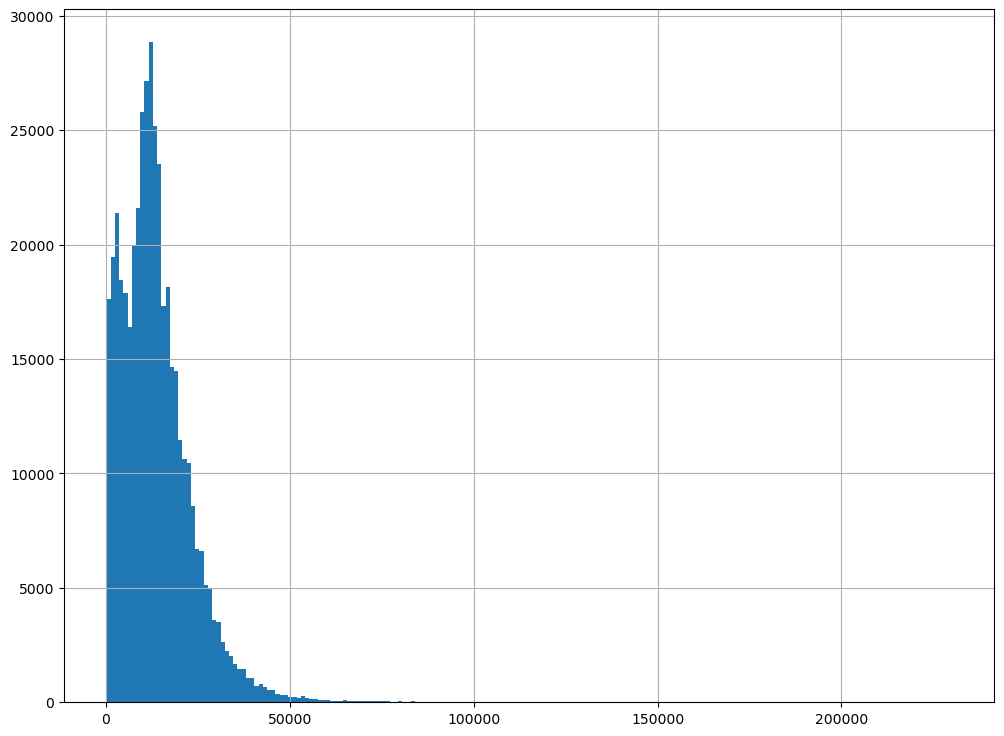

In [40]:
# Проверка распрделения стоимости
train['sellingprice'].hist(bins=200, figsize=(12,9))

In [41]:
# Проверка корреляции
train.corr()

,year,condition,odometer,sellingprice,saleyaer,weekday,machineage
year,1.000000,0.559801,-0.774507,0.586763,0.115930,-0.048129,-0.997233
condition,0.559801,1.000000,-0.545090,0.545974,0.080315,-0.013786,-0.557121
odometer,-0.774507,-0.545090,1.000000,-0.583050,-0.088021,0.027358,0.772487
sellingprice,0.586763,0.545974,-0.583050,1.000000,0.077024,-0.001610,-0.584425
saleyaer,0.115930,0.080315,-0.088021,0.077024,1.000000,-0.147257,-0.041925
weekday,-0.048129,-0.013786,0.027358,-0.001610,-0.147257,1.000000,0.037390
machineage,-0.997233,-0.557121,0.772487,-0.584425,-0.041925,0.037390,1.000000


### test

In [42]:
# Проверка корреляции
test.corr()

,year,condition,odometer,saleyaer,weekday,machineage
year,1.000000,0.556109,-0.767801,0.110316,-0.045300,-0.997209
condition,0.556109,1.000000,-0.542167,0.077255,-0.007283,-0.553361
odometer,-0.767801,-0.542167,1.000000,-0.082895,0.021865,0.765743
saleyaer,0.110316,0.077255,-0.082895,1.000000,-0.149392,-0.035942
weekday,-0.045300,-0.007283,0.021865,-0.149392,1.000000,0.034328
machineage,-0.997209,-0.553361,0.765743,-0.035942,0.034328,1.000000


## Работа с выборками

### Вспомогательные функции

In [6]:
# Функция для LabelEncoder()
def LE(features_LE, test_LE, cat_columns):
    label_encoder = LabelEncoder()
    for i in cat_columns:
        kek = []
        kek = features_LE[i].append(test_LE[i])
        kek = kek.drop_duplicates()
        label_encoder.fit(kek)
        features_LE[i]= label_encoder.transform(features_LE[i])
        test_LE[i]= label_encoder.transform(test_LE[i])
    return features_LE, test_LE

In [6]:
# Функция для StandardScaler()

def scaler(features_train,features_test, columns):
    scaler = StandardScaler()

    scaler.fit(features_train[columns])

    features_train = features_train.copy()
    features_train[columns] = scaler.transform(features_train[columns])

    features_test = features_test.copy()
    features_test[columns] = scaler.transform(features_test[columns])
    return features_train, features_test

In [6]:
# Функция для get_dummies

def ohe(features_train, features_test):
    features_train = pd.get_dummies(features_train, drop_first=True)
    features_test = pd.get_dummies(features_test, drop_first=True)
    return features_train, features_test

In [7]:
# Функция для OHE()

def ohe_sk(features_train, features_test):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(features_train)
    features_train = enc.transform(features_train)
    features_test = enc.transform(features_test)
    return features_train, features_test

Готовлю три разных выборки. Оригинальная, закодированная LabelEncoder() и закодированная get_dummies, чтобы посмотреть какиая лучше сработает

In [20]:
test

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saleyaer,weekday,machineage
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.000000,black,black,santander consumer,2015,0,4
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.000000,black,black,ars/avis budget group,2015,1,1
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.000000,black,black,nissan-infiniti lt,2015,1,3
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.000000,gold,beige,wichita falls ford lin inc,2015,1,12
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.000000,black,black,purple heart,2015,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439422,2007,Ford,cabriolet,b2500 se,cab plus 4,automatic,fl,2.0,136386.000000,white,tan,broward county sheriffs office,2015,0,8
439831,2011,Chevrolet,rdx,4x4 cr,wagon,automatic,qc,4.7,25883.000000,black,gray,financialinx,2015,0,4
97325,2010,chevrolet,equinox,lt1,suv,automatic,ab,1.0,168593.498647,blue,black,go auto finance,2015,2,5
179737,2000,buick,lesabre,custom,sedan,automatic,nc,1.0,163710.761241,white,—,crossroads nissan of wake forest,2014,6,14


In [7]:
features_original = train.drop('sellingprice', axis=1)
test_original = test.copy()
features_le = train.drop('sellingprice', axis=1)
test_le = test.copy()
features_ohe = train.drop('sellingprice', axis=1)
test_ohe = test.copy()
target = train['sellingprice']

In [8]:
features_ohe = train.drop('sellingprice', axis=1)
test_ohe = test.copy()

In [9]:
cat_columns = features_original.select_dtypes(include='object').columns.to_list()
numeric = features_original.select_dtypes(exclude='object').columns.to_list()

In [10]:
features_original, test_original = scaler(features_original, test_original, numeric)

In [28]:
%%time

features_le, test_le = LE(features_le, test_le, cat_columns)
features_le, test_le = scaler(features_le, test_le, numeric)

CPU times: user 478 ms, sys: 108 ms, total: 587 ms
Wall time: 585 ms


In [ ]:
for i in cat_columns:
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(features_ohe[i]))
    final_df_train = features_ohe.join(encoder_df)
    features_ohe = final_df_train.drop([i], axis=1 , inplace= True )
    encoder_df = pd.DataFrame(encoder.transform(test_ohe[i]))
    final_df_test = test_ohe.join(encoder_df)
    test_ohe = final_df_test.drop([i], axis=1 , inplace= True )

In [ ]:
%%time

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(features_ohe[cat_columns]).toarray())
final_df = features_ohe.join(encoder_df)
features_ohe = final_df.drop([cat_columns], axis=1 , inplace= True )

In [ ]:
%%time

encoder_df = pd.DataFrame(encoder.transform(test_ohe[cat_columns]).toarray())
final_df = test_ohe.join(encoder_df)
test_ohe = final_df.drop([cat_columns], axis=1 , inplace= True )

In [11]:
features_original_train, features_original_valid, target_original_train, target_original_valid = train_test_split(
    features_original, target, test_size=0.25, random_state=1234)

In [29]:
features_le_train, features_le_valid, target_le_train, target_le_valid = train_test_split(
    features_le, target, test_size=0.25, random_state=1234)

In [249]:
features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(
    features_ohe, target, test_size=0.25, random_state=1234)

## Обучение моделей

In [12]:
# Функция для вычисления mape

def mape(test, pred):
    test, pred = np.array(test), np.array(pred)
    mape = np.mean(np.abs((test - pred) / test))
    return mape

### DecisionTreeRegressor

#### Закодированная LE выборка

In [ ]:
%%time

model = DecisionTreeRegressor(random_state=12345)

max_depth = [x for x in range(2, 30)]
params = [{'max_depth':max_depth}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2, n_jobs = -1 ,
                   scoring='neg_mean_absolute_percentage_error')

clf.fit(features_le_train, target_le_train)
pred = clf.predict(features_le_valid)
MAPE_DTR = mape(target_le_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_DTR)

#### Закодированная OHE выборка

In [ ]:
%%time

model = DecisionTreeRegressor(random_state=12345)

max_depth = [x for x in range(2, 20)]
params = [{'max_depth':max_depth}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2, n_jobs = -1 ,
                   scoring='neg_mean_absolute_percentage_error')

clf.fit(features_ohe_train, target_ohe_train)
pred = clf.predict(features_ohe_valid)
MAPE_DTR = mape(target_ohe_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_DTR)

### CatBoost

#### Оригинальная выборка

In [13]:
%%time

model = CatBoostRegressor(random_state=1234, cat_features=['make', 'model', 'trim', 'body',
                                 'transmission', 'state','color',
                                 'interior', 'seller'], learning_rate=0.03, iterations=3000,
                         verbose=False)

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[1000, 3000],
                'verbose':[False]}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error')

clf.fit(features_original_train, target_original_train)

estimator = clf.best_estimator_
filename = "model_CBR_original.cbm"
pickle.dump(estimator, open(filename, 'wb'))

pred = clf.predict(features_original_valid)
MAPE_CBR_original = mape(target_original_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_CBR_original)

Best parameters:
{'iterations': 3000, 'learning_rate': 0.03, 'verbose': False}
MAPE: 0.17500094062322724
CPU times: user 21min 34s, sys: 25.1 s, total: 21min 59s
Wall time: 13min 14s


In [14]:
pred_test = clf.predict(test_original)

In [19]:
test_original

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saleyaer,weekday,machineage
0,0.220270,ford,edge,sel,suv,automatic,md,0.815728,0.826840,black,black,santander consumer,0.290437,-1.169835,-0.200710
1,0.986266,ford,fusion,se,sedan,automatic,mo,0.078862,-0.684562,black,black,ars/avis budget group,0.290437,-0.361482,-0.967540
2,0.475602,nissan,sentra,2.0 sl,sedan,automatic,nj,-1.289602,-0.597948,black,black,nissan-infiniti lt,0.290437,-0.361482,-0.456320
3,-1.822384,hummer,h2,base,suv,automatic,tx,-0.658003,1.209569,gold,beige,wichita falls ford lin inc,0.290437,-0.361482,1.844171
4,-0.801057,ford,fusion,sel,sedan,automatic,md,-1.500135,1.141713,black,black,purple heart,0.290437,-1.169835,0.821731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439422,-0.801057,Ford,cabriolet,b2500 se,cab plus 4,automatic,fl,-1.500135,1.305629,white,tan,broward county sheriffs office,0.290437,-1.169835,0.821731
439831,0.220270,Chevrolet,rdx,4x4 cr,wagon,automatic,qc,1.342061,-0.781869,black,gray,financialinx,0.290437,-1.169835,-0.200710
97325,-0.035061,chevrolet,equinox,lt1,suv,automatic,ab,-2.552801,1.914057,blue,black,go auto finance,0.290437,0.446870,0.054900
179737,-2.588379,buick,lesabre,custom,sedan,automatic,nc,-2.552801,1.821817,white,—,crossroads nissan of wake forest,-3.443082,3.680278,2.355391


In [18]:
len(pred_test)

430829

#### Закодированная LE выборка

In [ ]:
%%time

model = CatBoostRegressor(random_state=1234)

params = [{'learning_rate':[0.01, 0.03],
           'iterations':[1000, 3000],
                'verbose':[False]}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error')

clf.fit(features_le_train, target_le_train)

estimator = clf.best_estimator_
filename = "model_CBR_LE.cbm"
pickle.dump(estimator, open(filename, 'wb'))

pred = clf.predict(features_le_valid)
MAPE_CBR_LE = mape(target_le_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_CBR_LE)

### LGBMRegressor

#### Закодированная OHE выборка

In [ ]:
%%time


model = lgb.LGBMRegressor(random_state=1234, force_col_wise=True)

params = [{'learning_rate':[0.01, 0.03, 0.1],
           'iterations':[1000, 2000, 3000]}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error')

clf.fit(features_le_train, target_le_train)

estimator = clf.best_estimator_
filename = "model_LGBM_le.cbm"
pickle.dump(estimator, open(filename, 'wb'))

pred = clf.predict(features_le_valid)
MAPE_LGBM_le = mape(target_le_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_LGBM_le)

#### Закодированная LE выборка

In [ ]:
%%time


model = lgb.LGBMRegressor(random_state=1234, force_col_wise=True)

params = [{'learning_rate':[0.01, 0.03, 0.1],
           'iterations':[1000, 2000, 3000],
                'verbose':[1, False]}]

clf = GridSearchCV(estimator = model, param_grid = params, cv = 2,
                   n_jobs = -1, scoring='neg_mean_absolute_percentage_error')

clf.fit(features_ohe_train, target_ohe_train)

estimator = clf.best_estimator_
filename = "model_LGBM_ohe.cbm"
pickle.dump(estimator, open(filename, 'wb'))

pred = clf.predict(features_ohe_valid)
MAPE_LGBM_ohe = mape(target_ohe_valid, pred)
print("Best parameters:")
print(clf.best_params_)
print("MAPE:", MAPE_LGBM_ohe)

## Финальная модель

In [252]:
filename = "model_CBR_original.cbm"
model = pickle.load(open(filename, 'rb'))
pred_test = model.predict(test_original)
pred = model.predict(features_original_valid)
MAPE_CBR_original = mape(target_original_valid, pred)
print("MAPE на валидационной выборке:", MAPE_CBR_original)

MAPE на валидационной выборке: 0.17620170650673161


## Сбор итогового файла

In [39]:
vin= test['vin']

In [17]:
vin_test

,vin
0,1g6dp567450124779
1,1gtw7fca7e1902207
2,jn8az1mw6dw303497
3,2g1wf5e34d1160703
4,1n6aa0ec3dn301209
...,...
110053,1j4aa2d17bl584330
110054,jthbf1d23e5007526
110055,1n4ba41e54c831950
110056,jn1az4eh3dm382431


In [16]:
vin_test = pd.DataFrame(vin_test)
vin_test['sellingprice'] = pred_test
vin_test.to_csv(r'my_data.csv', index=False)
vin_test.head()

ValueError: Length of values (430829) does not match length of index (110058)

In [ ]:
submit = pd.read_csv('sample_submission.csv')
preds = pd.read_csv("save/"+target_name+"_predictions.csv")

submit[target_name] =  preds[target_name+"_predicted"].values

submit.to_csv("submission.csv", index=False)